# Track - Environmental Conservation

Prompt: Habitat Protection & Biodiversity Management
Explore AI-driven methods to identify and protect endangered species and fragile ecosystems. This
could include using drone imagery, camera traps, or acoustic data to track wildlife patterns and
detect illegal activities like poaching or deforestation.

## GiS Processing

### Detecting Algae Bloom using Remote Sensing



###Demo Explanation: Algal Bloom Detection Approach
Data Collection & Preparation

Satellite Imagery: We used Sentinel-2 Level-2A data (surface reflectance) for a specified date range (August 2020) in Biscayne Bay.
Chlorophyll Proxy: We computed a simplified “chlorophyll” index by combining the NDVI with a Green/Red ratio.
Thresholding: We defined “bloom” where the chlorophyll index exceeded 0.15, creating polygons labeled 1. Areas at or below 0.15 were labeled 0 (“no bloom”).
Polygon Export

Using Google Earth Engine, we vectorized bloom and no-bloom areas and exported them to Google Drive as GeoJSON.
This gave us a two-class labeled dataset: bloom vs. no bloom.
Sentinel-2 Composite

We also exported a median composite of the same Sentinel-2 images as a GeoTIFF, focusing on the key bands: Blue (B2), Green (B3), Red (B4), and NIR (B8).
RandomForest Training

Sampling: We randomly sampled pixels inside each polygon (bloom or no bloom) and extracted the corresponding band values from the GeoTIFF.
Labels: Bloom polygons got label 1, no-bloom polygons got label 0.
Model: We trained a RandomForest classifier in Python (scikit-learn), performing a small grid search for hyperparameter tuning (e.g., n_estimators, max_depth).
Results & Caveats

Perfect Accuracy: On our demo dataset, the RandomForest achieved 100% accuracy. This occurs because the training labels came directly from the threshold rule, so the model simply “re-learns” that threshold.
Future Validation: In real-world applications, we’d test on independent data or incorporate field observations (in situ measurements) to ensure the model generalizes beyond the original threshold-based labeling.
Next Steps

Refine Threshold: Adjust or use more advanced indices (like FAI, NDWI, etc.) for better detection.
Collect Real Negative Samples: Acquire data from times/locations known to have no blooms, or manually digitize no-bloom areas for a more robust training set.
Validation: Compare model predictions against true bloom events from external sources (agency data, lab measurements).
Integration: Once validated, integrate the trained model into a monitoring dashboard (e.g., Angular/Leaflet or Mapbox) for near real-time bloom alerts.

## Data Processing

In [ ]:
# -- Installs --

!pip install sentinelsat rasterio numpy matplotlib scikit-learn
!pip install requests

In [3]:
# -- Imports --
import ee
import folium
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
from google.colab import auth
import google
import geemap


import rasterio
from shapely.geometry import mapping
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split

import os
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import matplotlib.pyplot as plt

import requests
import json

#### Generating Training Data

#### EE API Authentication

In [4]:
# Authenticate the notebook.
auth.authenticate_user()

In [5]:
PROJECT = 'ee-thaliasaxo99'

# Authenticate to Earth Engine.
credentials, _ = google.auth.default()
ee.Initialize(credentials, project=PROJECT, opt_url='https://earthengine-highvolume.googleapis.com')

#### Getting Data From Biscayne Bay from August 2020

In [8]:
# Rough bounding box for Biscayne Bay (west, south, east, north)
roi = ee.Geometry.Rectangle([-80.2, 25.5, -80.0, 25.8])

# Example date window around August 2020 (when a notable fish kill and bloom occurred)
start_date = '2020-08-01'
end_date   = '2020-08-31'


In [9]:
s2_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR")  # Level-2A
    .filterBounds(roi)
    .filterDate(start_date, end_date)
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # optional cloud filter
)
print("Number of Sentinel-2 images:", s2_collection.size().getInfo())


Number of Sentinel-2 images: 6


#### Getting Chlorofhyll Index using NDVI

In [15]:
def addChlorophyllIndex(image):
    # NDVI = (NIR - Red) / (NIR + Red) => (B8 - B4) / (B8 + B4)
    ndvi = image.normalizedDifference(['B8', 'B4'])  # B8 = NIR, B4 = Red

    # Chlorophyll proxy = (Green/Red) * NDVI => (B3 / B4) * NDVI
    green = image.select('B3')
    red   = image.select('B4')
    chl   = green.divide(red).multiply(ndvi).rename('CHL')

    return image.addBands(chl)

# Map the function over the collection
s2_with_chl = s2_collection.map(addChlorophyllIndex)


#### Creating Image Composites

In [16]:
s2_median = s2_with_chl.median().clip(roi)
# Now we have a single Image with a 'CHL' band
chl_band = s2_median.select('CHL')

s2_median_without_ch = s2_collection.median().clip(roi)


In [17]:
# Creating tiff

#  B2 (Blue), B3 (Green), B4 (Red), B8 (NIR)
bands_of_interest = ['B2','B3','B4','B8']
s2_median_subset = s2_median_without_ch.select(bands_of_interest)


# Export the composite to Google Drive
task = ee.batch.Export.image.toDrive(
    image = s2_median_subset,
    description = 'biscayne_s2_composite',
    folder = 'earth_engine_exports',  # or another folder name in your Drive
    fileNamePrefix = 'biscayne_s2_composite',
    region = roi.getInfo()['coordinates'],  # geometry for the export
    scale = 10,                             # Sentinel-2 resolution in meters
    crs = 'EPSG:4326',                      # optional, can use the default UTM
    fileFormat = 'GeoTIFF'
)
task.start()
print("Export task started. Monitor via ee.batch.Task.list() or Earth Engine Code Editor.")

Export task started. Monitor via ee.batch.Task.list() or Earth Engine Code Editor.


In [18]:
stats = chl_band.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=10,
    maxPixels=1e13
).getInfo()

print("CHL band min/max:", stats)


CHL band min/max: {'CHL_max': 3.236755609512329, 'CHL_min': -1.5788304805755615}


In [19]:
threshold = 0.15  # Example threshold for demonstration
bloom_mask = chl_band.gt(threshold)
no_bloom_mask = chl_band.lte(threshold).selfMask()


In [23]:
# Land mask
water_occ = ee.Image("JRC/GSW1_3/GlobalSurfaceWater").select("occurrence")
# Create a boolean mask for areas with > 50% water occurrence (adjust threshold as needed)
water_mask = water_occ.gte(80)  # water_occ is [0..100]

In [24]:
Map = geemap.Map()
Map.centerObject(roi, 11)

# Show the CHL band as a grayscale
Map.addLayer(chl_band, {'min':0, 'max':0.3, 'palette':['blue','green','yellow','red']}, 'Chlorophyll Index')

# Masked bloom area
bloom_masked = bloom_mask.And(water_mask).selfMask()  # sets "no bloom" to transparent
Map.addLayer(bloom_masked, {'palette': ['magenta']}, 'Bloom Mask')

Map


Map(center=[25.64997119506408, -80.0999999999995], controls=(WidgetControl(options=['position', 'transparent_b…

In [22]:
bloom_vectors = bloom_mask.selfMask().reduceToVectors(
    geometry=roi,
    scale=10,
    geometryType='polygon',
    labelProperty='bloom',
    reducer=ee.Reducer.countEvery()
)

print("Bloom vector feature count:", bloom_vectors.size().getInfo())

Map.addLayer(bloom_vectors, {}, 'Bloom Polygons')
Map


Bloom vector feature count: 10771


Map(bottom=895059.0, center=[25.51657301134407, -79.99573090045585], controls=(WidgetControl(options=['positio…

In [26]:
no_bloom_vectors = no_bloom_mask.reduceToVectors(
    geometry=roi,
    scale=10,
    geometryType='polygon',
    labelProperty='label',
    reducer=ee.Reducer.countEvery()
).map(lambda f: f.set('label', 0))

In [27]:
# Merge them
all_vectors = bloom_vectors.merge(no_bloom_vectors)

Converitng to GeoDataframe

In [28]:
# task = ee.batch.Export.table.toDrive(
#     collection=all_vectors,
#     description='biscayne_bloom_noBloom_polygons',
#     folder='earth_engine_exports',  # optional
#     fileFormat='GeoJSON'
# )
# task.start()


In [16]:
tasks = ee.batch.Task.list()
for t in tasks:
    print(t.id, t.state)

IQB3VG4LWJ4Q2BDRCNROJOFO READY
PRI3KAWPOUAL436RLLBSNCR7 RUNNING
S6XEIGBVIAI2OCICKL4SCSLS COMPLETED
ZKB3547477S7BFWWF5O3AXQP COMPLETED
QDVRRX4RXIK3KWWNLTFQ7UCD COMPLETED
TNEUG77RB4VRZC2DCKYPJ5ST COMPLETED
JA6Y7LMNM4XAL5FZDV4IJF65 COMPLETED


In [14]:
# bloom_fc = bloom_vectors.getInfo()  # GeoJSON-like dict
# features = bloom_fc['features']

# gdf_list = []
# for f in features:
#     geom = f['geometry']
#     coords = geom['coordinates']
#     # Each feature is a polygon or multipolygon
#     if geom['type'] == 'Polygon':
#         poly = Polygon(coords[0])  # single ring
#         gdf_list.append({'geometry': poly, 'bloom': 1})
#     elif geom['type'] == 'MultiPolygon':
#         # If it's multipolygon, loop through each ring
#         for ring in coords:
#             poly = Polygon(ring[0])
#             gdf_list.append({'geometry': poly, 'bloom': 1})

# bloom_gdf = gpd.GeoDataFrame(gdf_list, crs="EPSG:4326")
# print("Number of polygons detected:", len(bloom_gdf))
# bloom_gdf.head()


EEException: Collection query aborted after accumulating over 5000 elements.

In [29]:
gdf = gpd.read_file("biscayne_bloom_noBloom_polygons.geojson")
print("Number of polygons:", len(gdf))
gdf.head()

Number of polygons: 12438


,id,bloom,count,label,geometry
0,1_-890557+284620,1.0,1,NaN,"POLYGON ((-80.0001 25.56785, -80.00001 25.5678..."
1,1_-890557+284907,1.0,2,NaN,"POLYGON ((-80.0001 25.59354, -80.00001 25.5935..."
2,1_-890557+284930,1.0,1,NaN,"POLYGON ((-80.0001 25.5957, -80.00001 25.5957,..."
3,1_-890557+284988,1.0,1,NaN,"POLYGON ((-80.0001 25.60091, -80.00001 25.6009..."
4,1_-890557+285060,1.0,1,NaN,"POLYGON ((-80.0001 25.60738, -80.00001 25.6073..."


In [18]:

polygons_gdf = gpd.read_file("biscayne_bloom_noBloom_polygons.geojson")
print(polygons_gdf['label'].value_counts(dropna=False))


label
NaN    10771
0.0     1667
Name: count, dtype: int64


In [19]:
# Drop any rows that have NaN in 'label'
polygons_gdf = polygons_gdf.dropna(subset=['label'])

# Ensure label is an integer (0 or 1)
polygons_gdf['label'] = polygons_gdf['label'].astype(int)

print(polygons_gdf['label'].value_counts(dropna=False))


label
0    1667
Name: count, dtype: int64


In [28]:
# Now we fine tune RandomForest usign our generated training data

############################################################
# 2. Load Labeled Polygons & Raster

print("Polygons loaded:", len(polygons_gdf))

# Load the Sentinel-2 composite (multi-band GeoTIFF)
raster_path = "biscayne_s2_composite.tif"
raster = rasterio.open(raster_path)
print("Raster bands:", raster.count)
print("Raster CRS:", raster.crs)

# Make sure polygons and raster share the same CRS
if polygons_gdf.crs.to_string() != str(raster.crs):
    polygons_gdf = polygons_gdf.to_crs(raster.crs)

############################################################
# 3. Random Sampling of Pixels Within Each Polygon
############################################################
X_samples = []
y_labels = []

POINTS_PER_POLYGON = 50  # Adjust as needed

for idx, row in polygons_gdf.iterrows():
    geom = row.geometry
    label = row['label']  # 1=bloom, 0=no bloom

    # bounding box
    minx, miny, maxx, maxy = geom.bounds

    points_collected = 0
    attempts = 0
    MAX_ATTEMPTS = 500

    while points_collected < POINTS_PER_POLYGON and attempts < MAX_ATTEMPTS:
        attempts += 1
        randx = np.random.uniform(minx, maxx)
        randy = np.random.uniform(miny, maxy)
        p = Point(randx, randy)

        if p.within(geom):
            # Convert (x,y) -> (row,col) in the raster
            rowcol = raster.index(randx, randy)  # (row, col)
            if (0 <= rowcol[0] < raster.height) and (0 <= rowcol[1] < raster.width):
                # read pixel values from each band
                pixel_values = []
                for b in range(1, raster.count + 1):
                    val = raster.read(
                        b,
                        window=((rowcol[0], rowcol[0]+1), (rowcol[1], rowcol[1]+1))
                    )
                    pixel_values.append(val[0][0])  # single pixel

                X_samples.append(pixel_values)
                y_labels.append(label)
                points_collected += 1

print("Total samples collected:", len(X_samples))

X = np.array(X_samples)
y = np.array(y_labels)

############################################################
# 4. Train/Test Split
############################################################
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

############################################################
# 5. Fine-Tune RandomForest with GridSearch
############################################################
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best cross-val score:", grid_search.best_score_)

best_rf = grid_search.best_estimator_
test_acc = best_rf.score(X_test, y_test)
print("Test accuracy on hold-out:", test_acc)


Polygons loaded: 1667
Raster bands: 4
Raster CRS: EPSG:4326
Total samples collected: 83350
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-val score: 1.0
Test accuracy on hold-out: 1.0


### Connecting to Sentinel API for extracting latest data

In [22]:

with open('sentinel_hub_access_token.json', 'r') as file:
    data = json.load(file)

In [23]:
# Setting Copernicus API Authentication
from oauthlib.oauth2 import BackendApplicationClient
from requests_oauthlib import OAuth2Session



# Your client credentials
client_id = data['client-id']
client_secret = data['client-secret']

# Create a session
client = BackendApplicationClient(client_id=client_id)
oauth = OAuth2Session(client=client)

# Get token for the session
token = oauth.fetch_token(token_url='https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token',
                          client_secret=client_secret, include_client_id=True)

# All requests using this session will have an access token automatically added
resp = oauth.get("https://sh.dataspace.copernicus.eu/configuration/v1/wms/instances")
print(resp.content)


b'[]'


Successfully retrieved data.
Chlorophyll TIFF image saved as chlorophyll.tiff


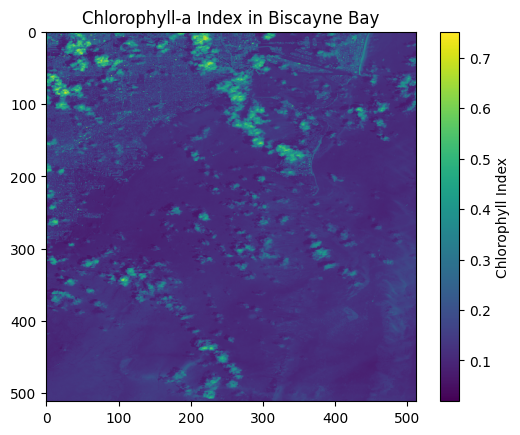

In [24]:

# 3.  Define Bounding Box and Evalscript for Chlorophyll-a
BBOX = [-80.3, 25.5, -80.1, 25.8]  # Biscayne Bay

EVALSCRIPT = """
//VERSION=3
function setup() {
  return {
    input: [
      {
        bands: ["B03", "B04", "B08"], // Green, Red, NIR
        units: "REFLECTANCE",
      },
    ],
    output: {
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32,
    },
  }
}

function evaluatePixel(sample) {
  let ndvi = (sample.B08 - sample.B04) / (sample.B08 + sample.B04);
  let chlorophyll = (sample.B03 / sample.B04) * ndvi;  // Simplified chlorophyll approximation
  return [sample.B03, sample.B04, sample.B08, chlorophyll];
}
"""

# 4. Construct Processing API Request
request = {
    "input": {
        "bounds": {
            "properties": {"crs": "http://www.opengis.net/def/crs/OGC/1.3/CRS84"},
            "bbox": BBOX,
        },
        "data": [
            {
                "type": "sentinel-2-l1c",
                "dataFilter": {
                    "timeRange": {
                        "from": "2020-08-01T00:00:00Z",
                        "to": "2020-08-31T00:00:00Z",
                    }
                },
            }
        ],
    },
    "output": {
        "width": 512,
        "height": 512,
        "responses": [
            {
                "identifier": "default",
                "format": {"type": "image/tiff"},
            }
        ],
    },
    "evalscript": EVALSCRIPT,
}


# 5. Make the Processing API Request
url = "https://sh.dataspace.copernicus.eu/api/v1/process"
response = oauth.post(url, json=request)


# 6. Handle the Response
if response.status_code == 200:
    print("Successfully retrieved data.")

    # Save the TIFF image
    with open("chlorophyll.tiff", "wb") as f:
        f.write(response.content)
    print("Chlorophyll TIFF image saved as chlorophyll.tiff")

    #  [NEW] Visualize the TIFF (requires rasterio and matplotlib)
    with rasterio.open("chlorophyll.tiff") as src:
        chlorophyll_data = src.read(1)  # Read the first band
        plt.imshow(chlorophyll_data, cmap='viridis') # Or any other suitable colormap
        plt.colorbar(label='Chlorophyll Index')
        plt.title('Chlorophyll-a Index in Biscayne Bay')
        plt.show()


else:
    print(f"Error: {response.status_code} - {response.text}")

In [25]:
print("Status Code:", response.status_code)
print("Response Headers:", response.headers)
print("Response Content-Type:", response.headers.get("Content-Type"))


Status Code: 200
Response Headers: {'date': 'Sun, 23 Feb 2025 15:08:20 GMT', 'content-type': 'image/tiff', 'access-control-allow-origin': '*', 'access-control-allow-headers': 'origin,content-type,accept,accept-crs,authorization,cache-control', 'access-control-allow-credentials': 'true', 'access-control-allow-methods': 'GET, POST, PUT, DELETE, OPTIONS, HEAD, PATCH', 'access-control-max-age': '3600', 'x-processingunits-spent': '2.0', 'transfer-encoding': 'chunked'}
Response Content-Type: image/tiff


What we should do is create a function to build our request to which we pass the client "date" parameters to request an image from the given date range.

Once we get our image in tiff format we pass to our model for classification.

### Platform API

In [46]:
!pip install pyngrok
!pip install flask-ngrok pyngrok
!ngrok authtoken YOUR_NGROK_TOKEN

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [26]:
def process_and_visualize(image_content, rf_model):
    # image_content is the raw TIFF bytes
    try:
        with rasterio.open(BytesIO(image_content)) as src:
            chlorophyll_data = src.read(1)
    except rasterio.RasterioIOError as e:
        print(f"Rasterio error: {e}")
        return None

    rows, cols = chlorophyll_data.shape
    # Flatten for prediction
    flattened = chlorophyll_data.flatten().reshape(-1, 1)

    # Predict bloom (1) vs no bloom (0)
    predictions = rf_model.predict(flattened).reshape(rows, cols)

    return predictions


In [29]:
import joblib

# Save the best estimator to a file
joblib.dump(best_rf, "bloom_model.joblib")


['bloom_model.joblib']

In [30]:
model = joblib.load("bloom_model.joblib")

In [31]:
from io import BytesIO
predictions = process_and_visualize(response.content, model)



plt.imshow(predictions, cmap='RdYlGn')  # 1 = bloom, 0 = no bloom
plt.title('Bloom vs No Bloom Prediction')
plt.show()

ValueError: X has 1 features, but RandomForestClassifier is expecting 4 features as input.

In [35]:
import io
import base64
import matplotlib.pyplot as plt
import rasterio

def chlorophyll_tiff_to_base64(tiff_path):
    """
    Reads the single-band 'chlorophyll' TIFF, colorizes it with matplotlib,
    and returns a base64-encoded PNG string.
    """
    with rasterio.open(tiff_path) as src:
        chl_data = src.read(1)  # single band

    # Create a matplotlib figure
    fig, ax = plt.subplots(figsize=(5,5))
    cax = ax.imshow(chl_data, cmap='viridis')
    plt.colorbar(cax, ax=ax, label='Chlorophyll Index')
    ax.set_title('Chlorophyll in Biscayne Bay')
    ax.axis('off')

    # Save to an in-memory buffer
    buf = io.BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    buf.seek(0)

    # Convert to base64
    return base64.b64encode(buf.read()).decode('utf-8')


In [39]:
base64_png = chlorophyll_tiff_to_base64("chlorophyll.tiff")

with open("chlorophyll_base64.txt", "w") as f:
    f.write(base64_png)
    print("Wrote base64 PNG to chlorophyll_base64.txt")

Wrote base64 PNG to chlorophyll_base64.txt


In [ ]:
#Just for demostrattion assume this is the prediction result


In [41]:
from pyngrok import ngrok

with open('ngrok_token.txt', 'r') as file:
    ngrok_token = file.read().strip()

ngrok.set_auth_token(ngrok_token)

http_tunnel = ngrok.connect(5000)
print(http_tunnel.public_url)

https://f7a5-34-148-131-57.ngrok-free.app


In [42]:
from flask import Flask, request, jsonify
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from flask_ngrok import run_with_ngrok
from pyngrok import ngrok

app = Flask(__name__)
run_with_ngrok(app)


@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    # Process data and run model inference ( we will get the user filter parameters)

    # We would call the predict function and give our parameters
    # Another function will convert the output to a base64 image"
    #prediction = model.predict(data)

    # For demo we are simulating the final image output
    base64_png = chlorophyll_tiff_to_base64("chlorophyll.tiff")
    return jsonify({"image": base64_png})

# if __name__ == '__main__':
#     app.run(debug=True)

In [43]:
# Running server
if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://f7a5-34-148-131-57.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/Feb/2025 15:36:10] "POST /predict HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [23/Feb/2025 15:53:22] "POST /predict HTTP/1.1" 200 -
